数据集的前几行：
   id  loanAmnt  term  interestRate  installment grade subGrade  \
0   0     42000     5     21.674228   927.134668     E       E2   
1   1     23000     5     15.036774   502.313142     D       D2   
2   2     18000     5     17.850663   273.198985     D       D3   
3   3     12000     3      7.400815   318.462279     A       A4   
4   6      8000     3      8.555855    61.865542     A       A4   

   employmentTitle  annualIncome  isDefault  purpose        dti  ficoRangeLow  \
0            320.0      111000.0          1        1  12.561763           728   
1         219843.0       52000.0          0        0  28.313509           699   
2          31698.0       77000.0          0        0  24.416141           673   
3          46854.0      119000.0          0        4  19.105931           682   
4         180083.0       36000.0          0        0  16.314634           754   

   openAcc  revolBal  totalAcc earliesCreditLine   title  policyCode  
0        8     24179        28

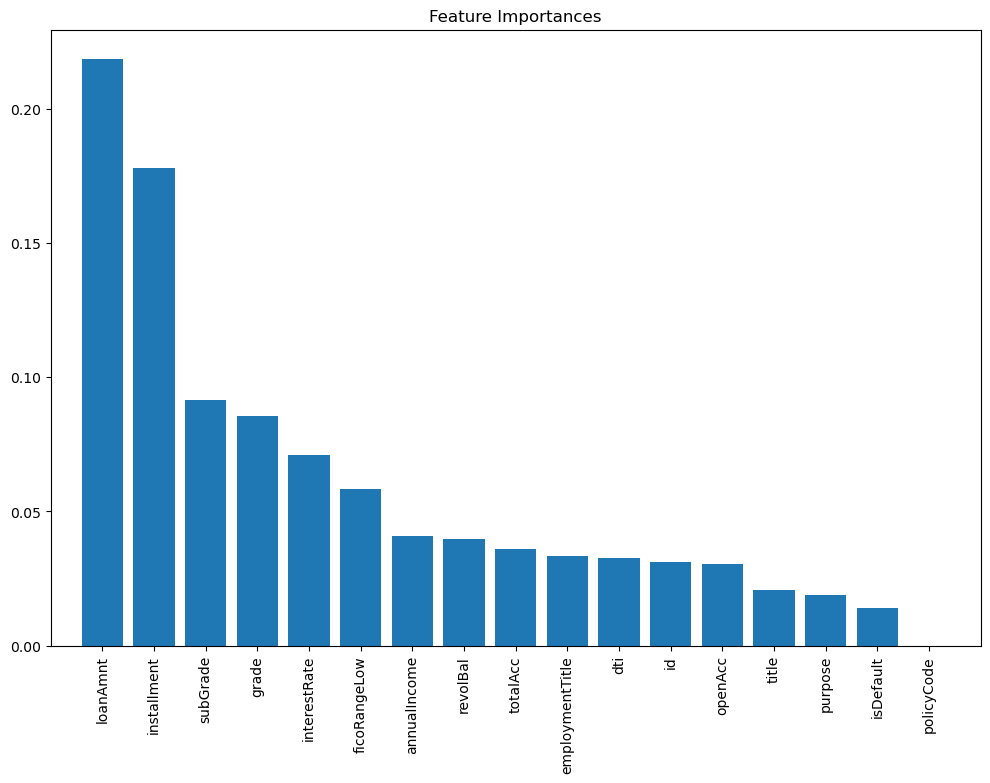

原始特征数量: 17
PCA 之后的特征数量: 12
所选特征：
Index(['loanAmnt', 'interestRate', 'installment', 'subGrade', 'isDefault',
       'purpose', 'dti', 'ficoRangeLow', 'revolBal', 'totalAcc'],
      dtype='object')
Logistic Regression:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95    106082
           1       0.86      0.78      0.82     33609

    accuracy                           0.92    139691
   macro avg       0.90      0.87      0.88    139691
weighted avg       0.91      0.92      0.91    139691

Gradient Boosting Decision Trees (GBDT):
              precision    recall  f1-score   support

           0       0.94      0.97      0.96    106082
           1       0.90      0.82      0.85     33609

    accuracy                           0.93    139691
   macro avg       0.92      0.89      0.91    139691
weighted avg       0.93      0.93      0.93    139691

Multi-Layer Perceptron (MLP):
              precision    recall  f1-score   support

   

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, RandomizedSearchCV, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier,GradientBoostingClassifier,RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,make_scorer,accuracy_score, precision_score, recall_score, f1_score
from scipy.stats import randint 
from sklearn.svm import SVC

# 导入数据集
file_path = r'E:\python练习\2week\data_副本.csv'# 替换为实际文件路径
data = pd.read_csv(file_path)

#随机抽取数据的 30%
data_sample = data.sample(frac=0.3, random_state=42)  # frac=0.3 表示抽取 30% 的数据

# 查看数据集的前几行和列名
print("数据集的前几行：")
print(data.head())
print("\n数据集的列名：")
print(data.columns)
print("\n数据集的数据类型：")
print(data.dtypes)

# 去除日期列
if 'earliesCreditLine' in data.columns:
    data = data.drop(columns=['earliesCreditLine'])

# 处理非数值数据
# 将所有非数值列转换为数值列（例如，将类别数据转换为数值编码）
for column in data.columns:
    if data[column].dtype == 'object':
        data[column] = pd.Categorical(data[column]).codes

print("\n缺失值检查：")
print(data.isnull().sum())

# 再次查看数据集的前几行和列名
print("\n转换后的数据集的前几行：")
print(data.head())
print("\n转换后的数据集的数据类型：")
print(data.dtypes)

## 区分特征和标签
labels = data.iloc[:, 2]       # 选择除 'interestRate' 之外的所有列作为特征
features = data.drop(data.columns[2], axis=1)    # 选择 'interestRate' 作为标签

print("\n标签列名：")
print(data.columns[2])

# 检查标签的唯一值
print("\n标签的唯一值：")
print(labels.unique())


# 将标签转换为分类类型
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
# 分割数据集，80%作为训练集，20%作为测试集
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.2, random_state=42)

# 标准化特征
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.transform(X_test)

# 特征选择
model = ExtraTreesClassifier()
model.fit(X_train_standardized, y_train)
# 输出特征重要度
print("特征重要度：")
print(model.feature_importances_)

# 训练 ExtraTreesClassifier 并获取特征重要性
model = ExtraTreesClassifier()
model.fit(X_train_standardized, y_train)

# 获取特征重要性
importances = model.feature_importances_

# 绘制特征重要性图表
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 8))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

# 保留 95% 的方差
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_standardized)
X_test_pca = pca.transform(X_test_standardized)

# 输出 PCA 之后的特征数量
print(f"原始特征数量: {X_train_standardized.shape[1]}")
print(f"PCA 之后的特征数量: {X_train_pca.shape[1]}")

# 使用逻辑回归作为基模型
model = LogisticRegression(max_iter=1000)
rfe = RFE(model, n_features_to_select=10)  # 选择 10 个特征
rfe.fit(X_train_standardized, y_train)

# 打印所选的特征
print("所选特征：")
print(X_train.columns[rfe.support_])

# 用所选特征训练模型
X_train_rfe = X_train_standardized[:, rfe.support_]
X_test_rfe = X_test_standardized[:, rfe.support_]

# 使用所选特征的训练集和测试集进行后续的模型训练和评估
# Logistic Regression
log_reg = LogisticRegression(C=0.1, l1_ratio=0.9, penalty='elasticnet', solver='saga', max_iter=10000)
log_reg.fit(X_train_standardized, y_train)
y_pred_log_reg = log_reg.predict(X_test_standardized)
print("Logistic Regression:")
print(classification_report(y_test, y_pred_log_reg))

# Gradient Boosting Decision Trees (GBDT)
gbdt = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, subsample=0.8, min_samples_split=2)
gbdt.fit(X_train_standardized, y_train)
y_pred_gbdt = gbdt.predict(X_test_standardized)
print("Gradient Boosting Decision Trees (GBDT):")
print(classification_report(y_test, y_pred_gbdt))

# Multi-Layer Perceptron (MLP)
mlp = MLPClassifier(hidden_layer_sizes=(50,), activation='relu', solver='adam', alpha=0.0001, learning_rate='constant', max_iter=200)
mlp.fit(X_train_standardized, y_train)
y_pred_mlp = mlp.predict(X_test_standardized)
print("Multi-Layer Perceptron (MLP):")
print(classification_report(y_test, y_pred_mlp))

In [ ]:
from scipy.stats import uniform
from random import randint
from scipy.stats import randint
from sklearn.model_selection import cross_val_score 

# 定义超参数分布
param_distributions = {
    'hidden_layer_sizes': [(50, 50), (100,), (150, 100, 50)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam', 'sgd'],
    'alpha': uniform(0.0001, 0.01),  # 使用均匀分布在 0.0001 到 0.01 之间采样
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': randint(200, 500)  # 在 200 到 500 之间的整数进行采样
}

# 定义交叉验证策略
cv = KFold(n_splits=3, shuffle=True, random_state=42)

# 定义随机搜索
random_search = RandomizedSearchCV(estimator=mlp, 
                                   param_distributions=param_distributions, 
                                   n_iter=20,  # 搜索 20 组参数组合
                                   cv=cv, 
                                   scoring='accuracy', 
                                   n_jobs=-1, 
                                   random_state=42, 
                                   verbose=2)

# 执行搜索
random_search.fit(X_train_standardized, y_train)

# 输出最佳参数和最佳得分
print("Best parameters found: ", random_search.best_params_)
print("Best accuracy score: ", random_search.best_score_)

# 使用最佳参数训练模型并在测试集上评估
best_mlp = random_search.best_estimator_
y_pred = best_mlp.predict(X_test_standardized)

# 计算模型的不同评分指标
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Test set accuracy: {accuracy}")
print(f"Test set precision: {precision}")
print(f"Test set recall: {recall}")
print(f"Test set F1-score: {f1}")


# 模型定义
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Support Vector Machine': SVC(kernel='linear', random_state=42)
}

# KFold 交叉验证
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# 使用 n_jobs=-1 进行并行计算
cv_results = cross_validate(models, X_train_standardized, y_train, cv=kf, n_jobs=-1, scoring='accuracy')

# 评分指标
scoring = {
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

# 交叉验证并比较模型性能
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f'{name} 交叉验证准确率: {scores.mean():.4f}')
# 打印结果

print("\n模型性能比较 (平均得分):")
for model_name, scores in results.items():
    print(f"{model_name}:")
    print(f"  Precision: {scores['precision_mean']:.4f}")
    print(f"  Recall: {scores['recall_mean']:.4f}")
    print(f"  F1 Score: {scores['f1_mean']:.4f}")

# 选择最佳模型
best_model = max(results, key=lambda x: results[x]['f1_mean'])
print(f"\n最佳模型: {best_model}")



Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters found:  {'activation': 'relu', 'alpha': 0.00621653160488281, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'adaptive', 'max_iter': 248, 'solver': 'adam'}
Best accuracy score:  0.936332348410918
Test set accuracy: 0.936703151956819
Test set precision: 0.8983754222293711
Test set recall: 0.8309083876342647
Test set F1-score: 0.8633258107397903


TypeError: estimator should be an estimator implementing 'fit' method, {'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42), 'Random Forest': RandomForestClassifier(random_state=42), 'Gradient Boosting': GradientBoostingClassifier(random_state=42), 'Support Vector Machine': SVC(kernel='linear', random_state=42)} was passed

In [2]:
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV, KFold, StratifiedKFold, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import numpy as np

# 定义 MLP 模型
mlp = MLPClassifier(random_state=42)

# 定义超参数分布
param_distributions = {
    'hidden_layer_sizes': [(50, 50), (100,), (150, 100, 50)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam', 'sgd'],
    'alpha': uniform(0.0001, 0.01),
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': randint(200, 500)
}

# 定义交叉验证策略
cv = KFold(n_splits=3, shuffle=True, random_state=42)

# 定义随机搜索
random_search = RandomizedSearchCV(estimator=mlp, 
                                   param_distributions=param_distributions, 
                                   n_iter=20, 
                                   cv=cv, 
                                   scoring='accuracy', 
                                   n_jobs=-1, 
                                   random_state=42, 
                                   verbose=2)

# 执行搜索
random_search.fit(X_train_standardized, y_train)

# 输出最佳参数和最佳得分
print("Best parameters found: ", random_search.best_params_)
print("Best accuracy score: ", random_search.best_score_)

# 使用最佳参数训练模型并在测试集上评估
best_mlp = random_search.best_estimator_
y_pred = best_mlp.predict(X_test_standardized)

# 计算模型的不同评分指标
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Test set accuracy: {accuracy}")
print(f"Test set precision: {precision}")
print(f"Test set recall: {recall}")
print(f"Test set F1-score: {f1}")


# 模型定义
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Support Vector Machine': SVC(kernel='linear', random_state=42)
}

# 使用 StratifiedKFold 交叉验证
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# 初始化结果字典
results = {}

# 定义评分指标
scoring = {
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

# 交叉验证并比较模型性能
for name, model in models.items():
    # 交叉验证准确率
    accuracy_scores = cross_val_score(model, X_train_standardized, y_train, cv=kf, scoring='accuracy')
    print(f'{name} 交叉验证准确率: {accuracy_scores.mean():.4f}')
    
    # 交叉验证其他评分指标
    cv_results = cross_validate(model, X_train_standardized, y_train, cv=kf, scoring=scoring, n_jobs=-1)
    
    # 记录结果
    results[name] = {
        'precision_mean': np.mean(cv_results['test_precision']),
        'recall_mean': np.mean(cv_results['test_recall']),
        'f1_mean': np.mean(cv_results['test_f1'])
    }

# 打印结果
print("\n模型性能比较 (平均得分):")
for model_name, scores in results.items():
    print(f"{model_name}:")
    print(f"  Precision: {scores['precision_mean']:.4f}")
    print(f"  Recall: {scores['recall_mean']:.4f}")
    print(f"  F1 Score: {scores['f1_mean']:.4f}")

# 选择最佳模型
best_model = max(results, key=lambda x: results[x]['f1_mean'])
print(f"\n最佳模型: {best_model}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters found:  {'activation': 'relu', 'alpha': 0.0031461376917337066, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'adaptive', 'max_iter': 291, 'solver': 'adam'}
Best accuracy score:  0.9364522577050982
Test set accuracy: 0.9372472099133087
Test set precision: 0.9365121127672249
Test set recall: 0.9372472099133087
Test set F1-score: 0.9367114823680561
Logistic Regression 交叉验证准确率: 0.9158
Random Forest 交叉验证准确率: 0.9328
Gradient Boosting 交叉验证准确率: 0.9280
Support Vector Machine 交叉验证准确率: 0.9160

模型性能比较 (平均得分):
Logistic Regression:
  Precision: 0.9142
  Recall: 0.9158
  F1 Score: 0.9144
Random Forest:
  Precision: 0.9318
  Recall: 0.9328
  F1 Score: 0.9319
Gradient Boosting:
  Precision: 0.9268
  Recall: 0.9280
  F1 Score: 0.9264
Support Vector Machine:
  Precision: 0.9143
  Recall: 0.9160
  F1 Score: 0.9144

最佳模型: Random Forest
